In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [2]:
# Read in the data from mysql
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
df = pd.read_sql('''SELECT * FROM logs LEFT JOIN cohorts ON cohorts.id = logs.cohort_id;''', url)

In [3]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


### Creating separate columns for each portion of the 'path'...not sure what to call them yet

In [4]:
df['path_1'] = df.path.str.split('/').str[0]

df['path_2'] = df.path.str.split('/').str[1]

df['path_3'] = df.path.str.split('/').str[2]

df['path_4'] = df.path.str.split('/').str[3]

In [14]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,path_1,path_2,path_3,path_4
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,,,NaN,NaN
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,NaN,NaN,NaN
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,object-oriented-programming,NaN,NaN
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,slides,object_oriented_programming,NaN,NaN
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,javascript-i,conditionals,NaN,NaN


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id          847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       object 
 14  program_id  847330 non-null  float64
 15  path_1      900222 non-null  object 
 16  path_2      731934 non-null  object 
 17  path_3      226870 non-null  object 
 18  path_4      26309 non-null   object 
dtypes:

In [19]:
# Make a copy before I get too deep into cleaning
df_copy = df.copy()

In [20]:
df_copy.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,path_1,path_2,path_3,path_4
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,,,NaN,NaN
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,NaN,NaN,NaN
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,object-oriented-programming,NaN,NaN
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,slides,object_oriented_programming,NaN,NaN
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,javascript-i,conditionals,NaN,NaN


In [24]:
df = df_copy

In [25]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,path_1,path_2,path_3,path_4
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,,,NaN,NaN
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,NaN,NaN,NaN
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,object-oriented-programming,NaN,NaN
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,slides,object_oriented_programming,NaN,NaN
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,javascript-i,conditionals,NaN,NaN


#### Create a date and time column

In [26]:
df['date'] = df['date'].str.cat(df['time'],sep=" ")

In [29]:
df.date = pd.to_datetime(df.date)

In [30]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,path_1,path_2,path_3,path_4
0,2018-01-26 09:55:03,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,,,NaN,NaN
1,2018-01-26 09:56:02,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,NaN,NaN,NaN
2,2018-01-26 09:56:05,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,object-oriented-programming,NaN,NaN
3,2018-01-26 09:56:06,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,slides,object_oriented_programming,NaN,NaN
4,2018-01-26 09:56:24,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,javascript-i,conditionals,NaN,NaN


##### Set and sort the index

In [31]:
df.set_index(df.date, inplace = True)

In [33]:
df.sort_index()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,path_1,path_2,path_3,path_4
date,,,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,2018-01-26 09:55:03,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,,,NaN,NaN
2018-01-26 09:56:02,2018-01-26 09:56:02,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,NaN,NaN,NaN
2018-01-26 09:56:05,2018-01-26 09:56:05,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,object-oriented-programming,NaN,NaN
2018-01-26 09:56:06,2018-01-26 09:56:06,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,slides,object_oriented_programming,NaN,NaN
2018-01-26 09:56:24,2018-01-26 09:56:24,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,javascript-i,conditionals,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,2021-04-21 16:41:51,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,jquery,personal-site,NaN,NaN
2021-04-21 16:42:02,2021-04-21 16:42:02,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,jquery,mapbox-api,NaN,NaN
2021-04-21 16:42:09,2021-04-21 16:42:09,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,jquery,ajax,weather-map,NaN


In [35]:
df.drop(columns=['date','time'], inplace=True)

In [36]:
df.head()

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,path_1,path_2,path_3,path_4
date,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,,,NaN,NaN
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,NaN,NaN,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,object-oriented-programming,NaN,NaN
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,slides,object_oriented_programming,NaN,NaN
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,javascript-i,conditionals,NaN,NaN


#### Replace program id values

In [38]:
df.program_id.value_counts()

2.0    713365
3.0    103412
1.0     30548
4.0         5
Name: program_id, dtype: int64

In [39]:
df.program_id.replace([1.0,2.0,3.0,4.0], ['php','java','ds','fe'], inplace=True)


In [40]:
df.head()

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,path_1,path_2,path_3,path_4
date,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,php,,,NaN,NaN
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,php,java-ii,NaN,NaN,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,php,java-ii,object-oriented-programming,NaN,NaN
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,php,slides,object_oriented_programming,NaN,NaN
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,java,javascript-i,conditionals,NaN,NaN


#### This tells us user_id's can have multiple ip's

In [42]:
len(df.user_id.unique())

981

In [43]:
len(df.ip.unique())

5531

#### rename id to cohort_id

In [45]:
df.rename(columns={'id':'cohort_id'}, inplace=True)

#### drop slack column

In [47]:
df.name.unique()

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', None, 'Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Staff',
       'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos',
       'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Everglades',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Neptune', 'Florence', 'Oberon'], dtype=object)

In [48]:
df.slack.unique()

array(['#hampton', '#teddy', '#sequoia', '#arches', '#niagara',
       '#pinnacles', '#quincy', None, '#kings', '#lassen', '#mammoth',
       '#glacier', '#denali', '#joshua', '#olympic', '#ulysses',
       '#badlands', '#apollo', '#ike', '#voyageurs', '#wrangell',
       '#xanadu', '#franklin', '#yosemite', '#', '#zion', '#andromeda',
       '#betelgeuse', '#ceres', '#deimos', '#europa', '#fortuna',
       '#curie', '#apex', '#ganymede', '#everglades', '#hyperion',
       '#darden', '#bash', '#jupiter', '#kalypso', '#luna', '#easley',
       '#marco', '#neptune', '#florence', '#oberon'], dtype=object)

In [49]:
# Drop slack column
df.drop(columns='slack',inplace=True)

In [50]:
df.head()

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,deleted_at,program_id,path_1,path_2,path_3,path_4
date,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,php,,,NaN,NaN
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,php,java-ii,NaN,NaN,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,php,java-ii,object-oriented-programming,NaN,NaN
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,php,slides,object_oriented_programming,NaN,NaN
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,java,javascript-i,conditionals,NaN,NaN


In [51]:
# Drop this column
df.deleted_at.value_counts()

Series([], Name: deleted_at, dtype: int64)

In [52]:
df.drop(columns='deleted_at',inplace=True)

In [55]:
df.head(15)

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4
date,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,,,NaN,NaN
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,java-ii,NaN,NaN,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,java-ii,object-oriented-programming,NaN,NaN
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,slides,object_oriented_programming,NaN,NaN
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,java,javascript-i,conditionals,NaN,NaN
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,java,javascript-i,loops,NaN,NaN
2018-01-26 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,java,javascript-i,conditionals,NaN,NaN
2018-01-26 09:56:48,javascript-i/functions,3,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,java,javascript-i,functions,NaN,NaN
2018-01-26 09:56:59,javascript-i/loops,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,java,javascript-i,loops,NaN,NaN


#### All of these columns are unique to each cohort

In [60]:
len(df.start_date) == len(df.name)

True

In [61]:
len(df.created_at) == len(df.name)

True

In [62]:
len(df.updated_at) == len(df.name)

True

#### Create hour column

In [65]:
df['hour'] = df.index.hour

In [66]:
df.head()

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,,,NaN,NaN,9
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,java-ii,NaN,NaN,NaN,9
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,java-ii,object-oriented-programming,NaN,NaN,9
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,slides,object_oriented_programming,NaN,NaN,9
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,java,javascript-i,conditionals,NaN,NaN,9


In [67]:
df.hour.value_counts()

9     131831
11     93809
10     89329
14     88899
15     81597
13     73660
16     66155
8      49639
12     49114
17     24070
21     23810
20     23452
19     20259
22     19788
18     19422
23     13389
7      11323
0       6710
6       4332
1       3468
5       2014
2       1860
4       1177
3       1116
Name: hour, dtype: int64

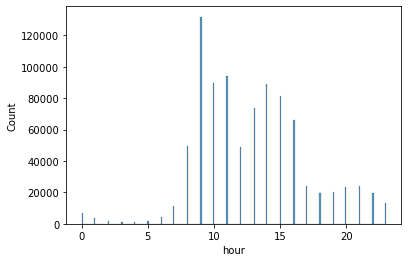

In [69]:
sns.histplot(df.hour)
plt.show()

In [72]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

#### checking out the ip column

In [76]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df

,count,proba
97.105.19.58,284579,0.316121
97.105.19.61,61662,0.068496
192.171.117.210,9515,0.010570
71.150.217.33,6791,0.007544
76.185.145.231,4754,0.005281
...,...,...
107.77.218.109,1,0.000001
107.77.169.49,1,0.000001
104.237.80.39,1,0.000001
172.56.6.109,1,0.000001


<AxesSubplot:>

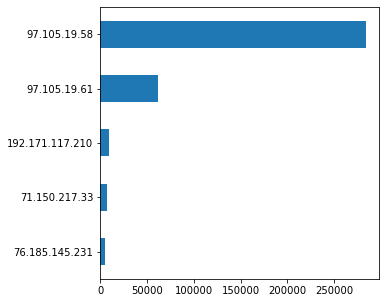

In [77]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))

#### Exploring the front end developer...pretty sure it's an anomaly or they decided to rename this program id

In [81]:
df.program_id.value_counts()

java    713365
ds      103412
php      30548
fe           5
Name: program_id, dtype: int64

In [82]:
df[df.program_id=='fe']

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2018-03-22 19:01:49,/,152,9.0,207.68.209.17,9.0,Apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,fe,,,NaN,NaN,19
2018-03-22 19:01:54,content/html-css,152,9.0,207.68.209.17,9.0,Apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,fe,content,html-css,NaN,NaN,19
2018-03-22 19:01:54,content/html-css/gitbook/images/favicon.ico,152,9.0,207.68.209.17,9.0,Apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,fe,content,html-css,gitbook,images,19
2018-03-22 19:02:47,content/html-css,152,9.0,207.68.209.17,9.0,Apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,fe,content,html-css,NaN,NaN,19
2018-03-22 19:02:52,content/html-css/introduction.html,152,9.0,207.68.209.17,9.0,Apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,fe,content,html-css,introduction.html,NaN,19


In [83]:
java_df = df[df.program_id=='java']

In [84]:
java_df.name.value_counts()

Staff         84031
Ceres         40730
Zion          38096
Jupiter       37109
Fortuna       36902
Voyageurs     35636
Ganymede      33844
Apex          33568
Deimos        32888
Teddy         30926
Hyperion      29855
Betelgeuse    29356
Ulysses       28534
Europa        28033
Xanadu        27749
Wrangell      25586
Andromeda     25359
Kalypso       23691
Yosemite      20743
Bash          17713
Luna          16623
Marco         16397
Sequoia        7444
Neptune        7276
Pinnacles      2158
Oberon         1672
Niagara         755
Mammoth         691
Name: name, dtype: int64

In [85]:
php_df = df[df.program_id=='php']

In [86]:
php_df.name.value_counts()

Lassen        9587
Arches        8890
Olympic       4954
Kings         2845
Hampton       1712
Quincy        1237
Glacier        598
Joshua         302
Ike            253
Badlands        93
Franklin        72
Denali           4
Everglades       1
Name: name, dtype: int64

In [88]:
php_df.path_1.value_counts()

content                 6397
javascript-i            3708
html-css                2463
spring                  2324
mysql                   2067
                        ... 
javascript-functions       1
handouts                   1
13.5_Tableau               1
6-regression               1
4.5_imports                1
Name: path_1, Length: 94, dtype: int64

In [89]:
java_df.path_1.value_counts()

javascript-i              110118
html-css                   79001
mysql                      77340
jquery                     56787
spring                     53149
                           ...  
f                              1
ltc-python                     1
Clustering_Explore             1
11.02_TransformData.md         1
javascri                       1
Name: path_1, Length: 589, dtype: int64

In [91]:
java_path_df = value_counts_and_frequencies(java_df.path_1)
java_path_df

,count,proba
javascript-i,110118,0.154364
html-css,79001,0.110744
mysql,77340,0.108416
jquery,56787,0.079604
spring,53149,0.074505
...,...,...
f,1,0.000001
ltc-python,1,0.000001
Clustering_Explore,1,0.000001
11.02_TransformData.md,1,0.000001


<AxesSubplot:>

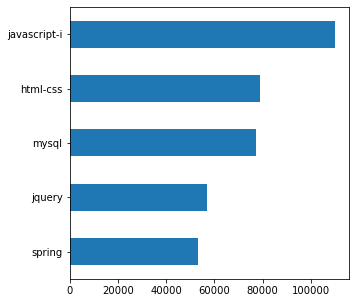

In [92]:
java_path_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))

In [93]:
php_path_df = value_counts_and_frequencies(php_df.path_1)
php_path_df

,count,proba
content,6397,0.209408
javascript-i,3708,0.121383
html-css,2463,0.080627
spring,2324,0.076077
mysql,2067,0.067664
...,...,...
javascript-functions,1,0.000033
handouts,1,0.000033
13.5_Tableau,1,0.000033
6-regression,1,0.000033


<AxesSubplot:>

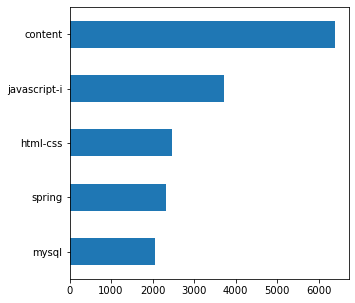

In [97]:
php_path_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))

In [101]:
ds_df = df[df.program_id=='ds']

In [123]:
ds_path_df = value_counts_and_frequencies(ds_df.path_1)

<AxesSubplot:>

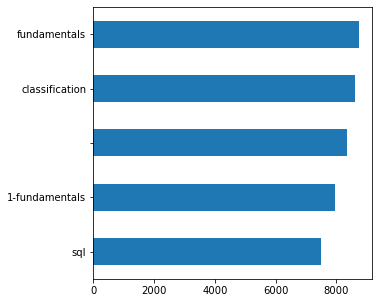

In [124]:
ds_path_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))